# Gaussian Fitting Sandbox

The jist of this notebook is to mess around with the gaussian fitting technique implemented in PSF_finder_one_order without accidentally breaking anything. Same dataset will be used, and the starting points will be identitcal.

The aim is to implement a minimum threshold for candidacy and work my way up to no threshold (if possible) and debug as I decrease the threshold. 

_Sources of Error and Places to Improve_
1. add assert statements throughout for debugging 
2. work on fine-tuning max and min requirements (without breaking code more)
> im going to try using np.percentile if this doesnt work generally

In [1]:
from scipy.optimize import curve_fit
import random

from astropy.io import fits
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import pandas as pd

In [2]:
import ipywidgets as widgets

In [3]:
data = pd.read_csv("C:\\Users\\alica\\workspace\\Intro-2-Spectra\\analysis\\NEID_analysis\\tau_ceti_shifted_spectrum.zip")
pd.set_option('display.max_rows', 10)
display(data)

,Unnamed: 0,shifted wavelength,shifted flux
0,0,5837.733295,0.950702
1,1,5837.752767,0.930930
2,2,5837.772240,1.008261
3,3,5837.791713,0.942884
4,4,5837.811185,1.003895
...,...,...,...
5601,5601,5947.824252,0.994086
5602,5602,5947.844092,0.963288
5603,5603,5947.863932,1.009402
5604,5604,5947.883772,1.008527


In [442]:
#reading in data: 
# wl = data['shifted wavelength'].to_numpy()
# fl = data['shifted flux'].to_numpy()


wl = wls[2]
fl = fls[2]

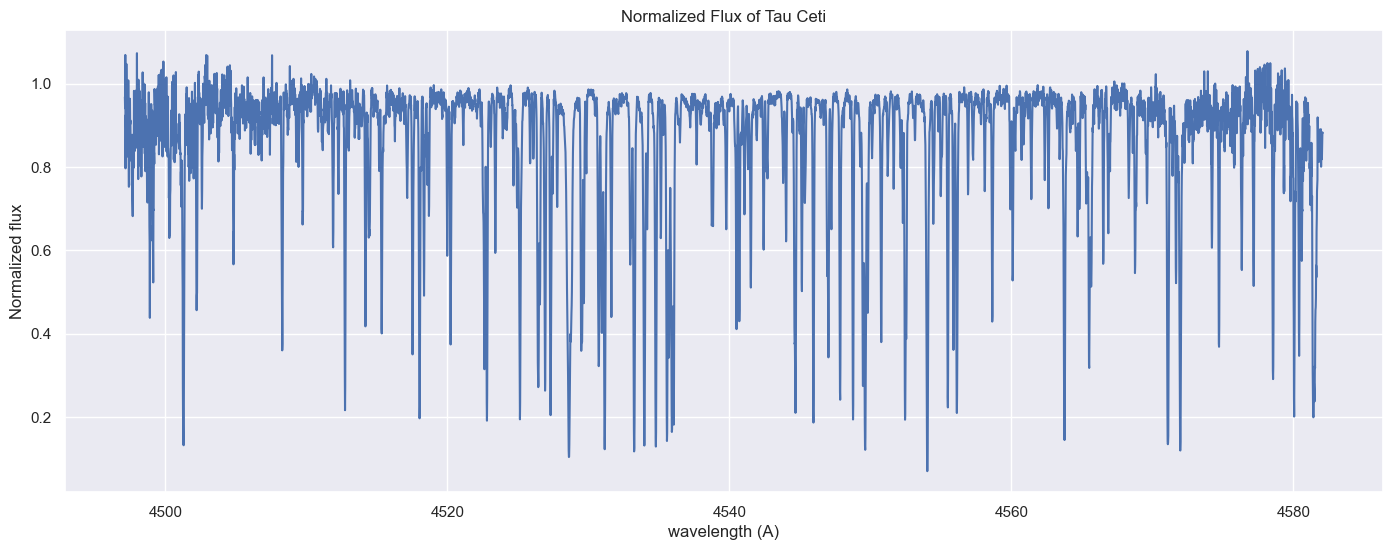

In [443]:
#visualization:
plt.figure(figsize = (17,6))
plt.plot(wl,fl)
plt.xlabel('wavelength (A)')
plt.ylabel('Normalized flux')
plt.title('Normalized Flux of Tau Ceti')
#plt.xlim(5884,5902)
plt.show()

## Finding Minima

In [444]:
def minima_scanner_simple(x,y):
    '''Finds minima through basic defintion: neighboring points are greater. takes in arrays of x and y values'''
    min_x = []
    min_y = []
    for i in np.arange(1,len(x)-1):
        if y[i-1] > y[i] and y[i] < y[i+1]:
            min_x.append(x[i])
            min_y.append(y[i]) 
    return min_x, min_y 

In [445]:
min_x, min_y = minima_scanner_simple(wl,fl)

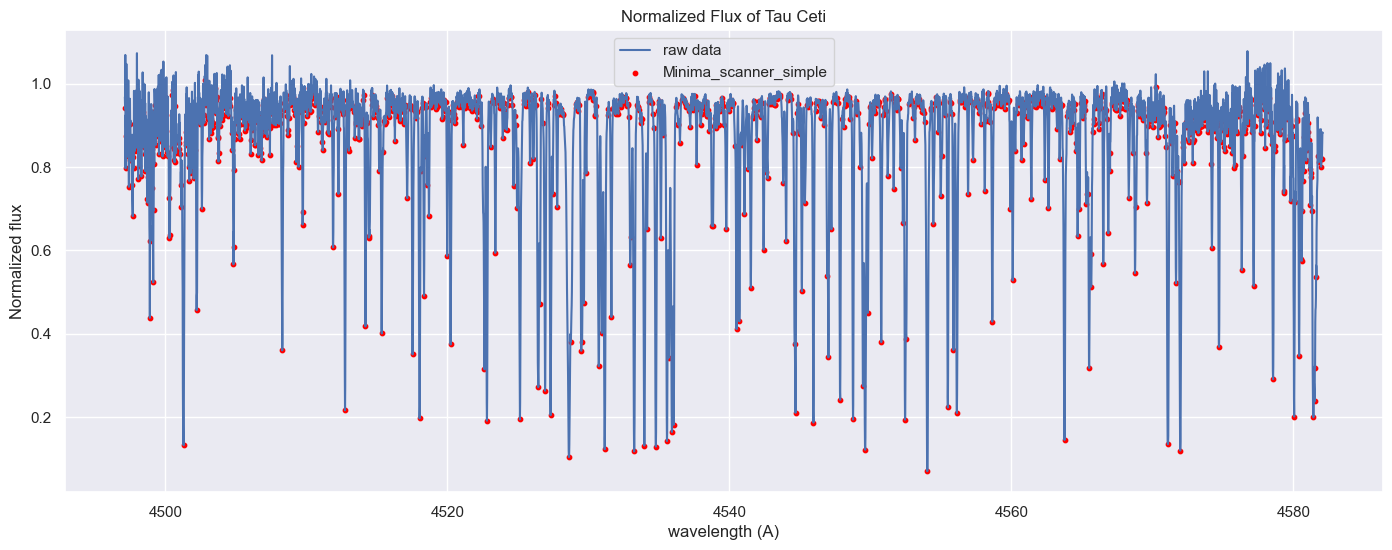

In [446]:
#visualization:
plt.figure(figsize = (17,6))
plt.plot(wl,fl, label = 'raw data')
plt.scatter(min_x, min_y, c = 'red', s= 10,label = 'Minima_scanner_simple')
plt.xlabel('wavelength (A)')
plt.ylabel('Normalized flux')
plt.title('Normalized Flux of Tau Ceti')
#plt.xlim(5884,5902)
plt.legend()
plt.show()


In [447]:

def minima_scanner_with_threshold(x,y, threshold): 
    ''' sets minima flux value to be considered for a minima (threshold). must be less than 1'''
    min_x = []
    min_y = []
    for i in np.arange(1, len(x)-1):
        if y[i] < threshold: 
            if y[i-1] > y[i] and y[i] < y[i+1]:
                min_x.append(x[i])
                min_y.append(y[i]) 
    return min_x, min_y   

In [448]:
min_x_thresh, min_y_thresh = minima_scanner_with_threshold(wl,fl,0.2)

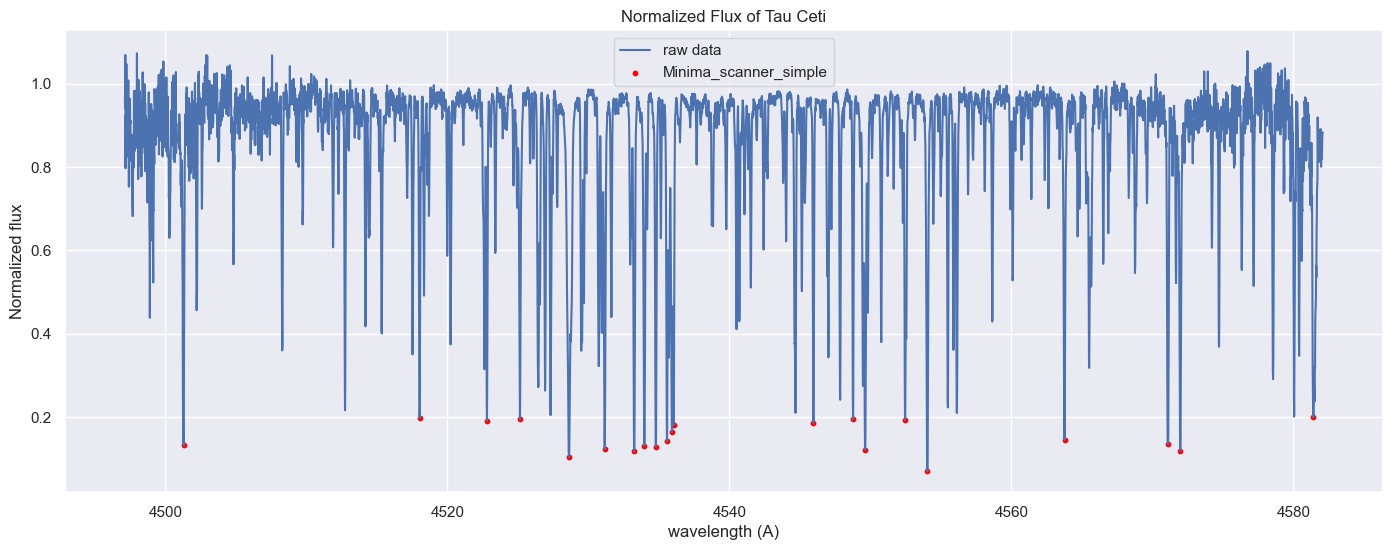

In [449]:
#visualization:
plt.figure(figsize = (17,6))
plt.plot(wl,fl, label = 'raw data')
plt.scatter(min_x_thresh, min_y_thresh, c = 'red', s= 10,label = 'Minima_scanner_simple')
plt.xlabel('wavelength (A)')
plt.ylabel('Normalized flux')
plt.title('Normalized Flux of Tau Ceti')
#plt.xlim(5884,5902)
plt.legend()
plt.show()

In [450]:
slider = widgets.FloatSlider(min = 0.1, max = 0.8, step = 0.1)

In [451]:
#plots mins at different thresholds
# for i in np.linspace(0.1, 0.8, 10):
#     minx, miny = minima_scanner_with_threshold(wl,fl, i)
#     plt.figure(figsize = (5,1))
#     plt.plot(wl, fl)
#     plt.scatter(minx,miny, c = 'orange',s = 3)
#     plt.title('Threshold of ' + str(i))
#     plt.show()

### Observations:

1. the lowest flux values correspond to the Calcium lines or the flux correction for nan values
> this leads me to believe that there should be a min and max threshold for gaussian candidates, as perhaps these low flux values are caused by extreme, broad absorption features, they for the most part wont be the features we are looking for

In [452]:
#this time, threshold will be an array:
def minima_scanner_with_thresholds(x,y, thresholds):
    ''' sets minima flux value to be considered for a minima (threshold). must be less than 1'''
    min_x = []
    min_y = []
    for i in np.arange(1, len(x)-1):
        if y[i] > thresholds[0] and y[i] < thresholds[1]: 
            if y[i-1] > y[i] and y[i] < y[i+1]:
                min_x.append(x[i])
                min_y.append(y[i]) 
    return min_x, min_y   

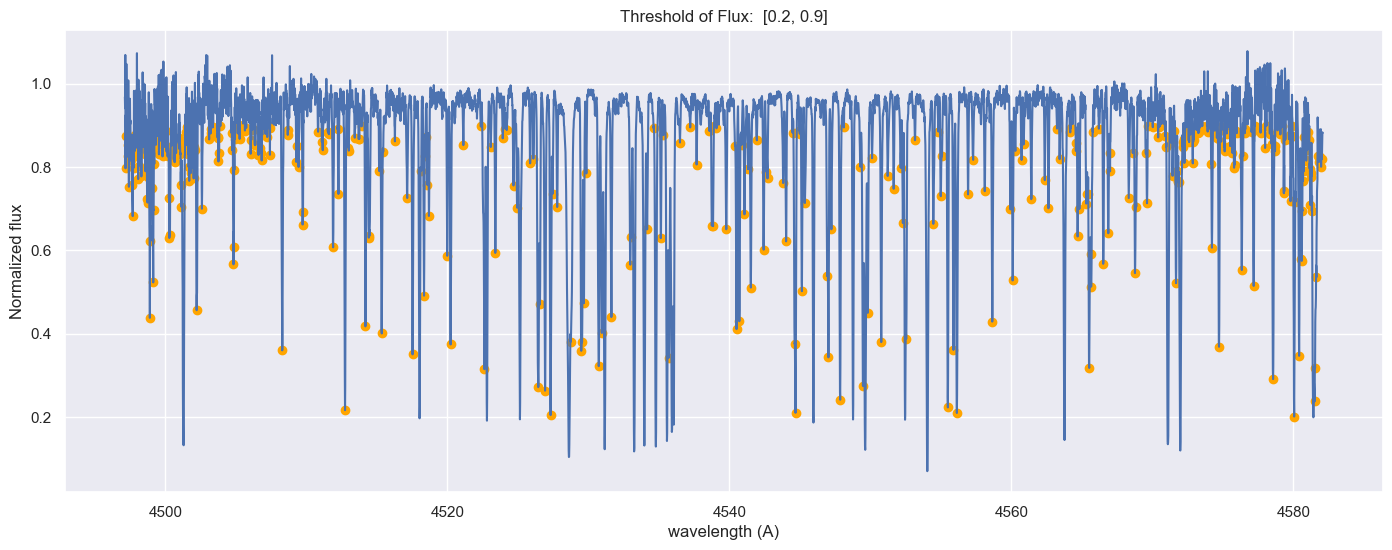

In [453]:
minx, miny = minima_scanner_with_thresholds(wl,fl, [0.2,0.90])

#minx, miny = minima_scanner_with_thresholds(wl,fl, i)
plt.figure(figsize = (17,6))
plt.plot(wl, fl)
plt.scatter(minx,miny, c = 'orange')
plt.title('Threshold of Flux:  ' + str([0.2,0.9]))
plt.xlabel('wavelength (A)')
plt.ylabel('Normalized flux')
plt.show()

_through observation it seems the given threshold range is the best, only time will tell if this is good enough!_

## Finding Maxima

thought: Can we put widgets in a function and it works how i think it will?

In [454]:
def simple_maxima(x, y, limit):
    ''' this requires min values and assumes a threshold has been applied'''
    l = limit #minimum value to be considered as a maxima 
    max_x = []
    max_y = []
    for i in np.arange(1, len(x)-1):
        if y[i] > l and y[i]:
            if y[i-1] < y[i] and y[i] > y[i+1]:
                max_x.append(x[i])
                max_y.append(y[i])
    return max_x, max_y
    
    

In [455]:
def find_maxima(x, y, minx, miny): ## this could be like, find the ones that occur closest to a minima and then make that the bois
    return ...

In [456]:
maxx, maxy = simple_maxima(wl,fl, 0.92)

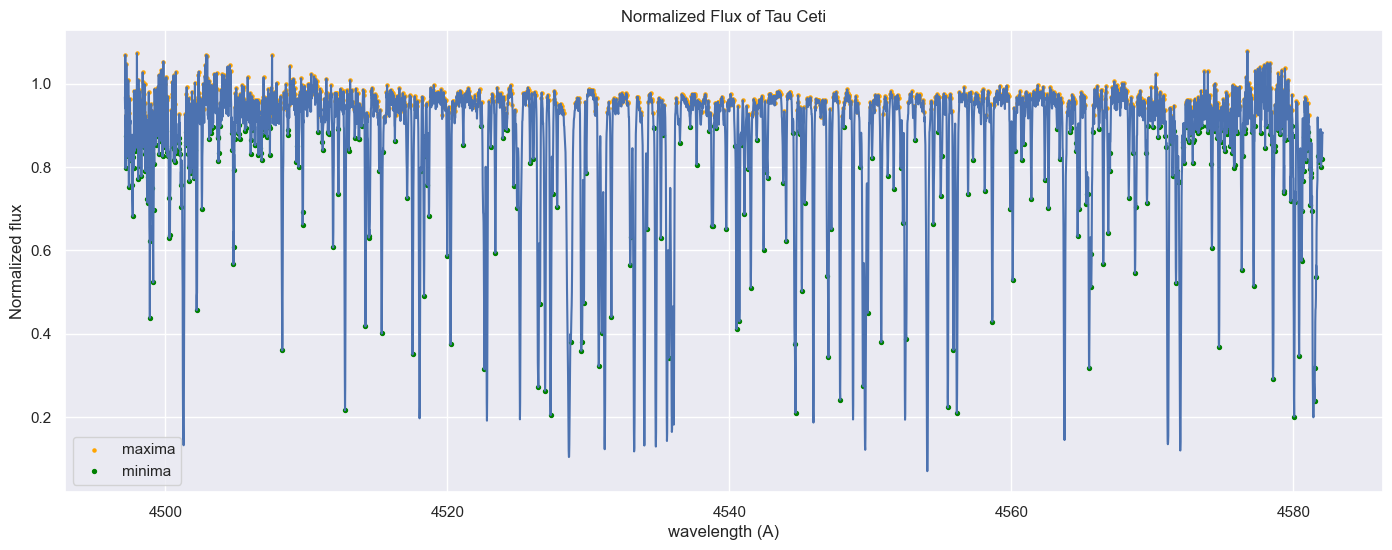

In [457]:
#visualization:
plt.figure(figsize = (17,6))
plt.plot(wl,fl)
plt.scatter(maxx, maxy,s = 5, c = 'orange', label = 'maxima')
plt.scatter(minx,miny,s = 8, c = 'green', label = 'minima')
plt.xlabel('wavelength (A)')
plt.ylabel('Normalized flux')
plt.title('Normalized Flux of Tau Ceti')
plt.legend()
#plt.xlim(5884,5902)
plt.show()

_this is giving helllaa maxima, but that might be good for now (unless it times out when we add more data points. Let's zoom in and do some smaller scale maxima searches_

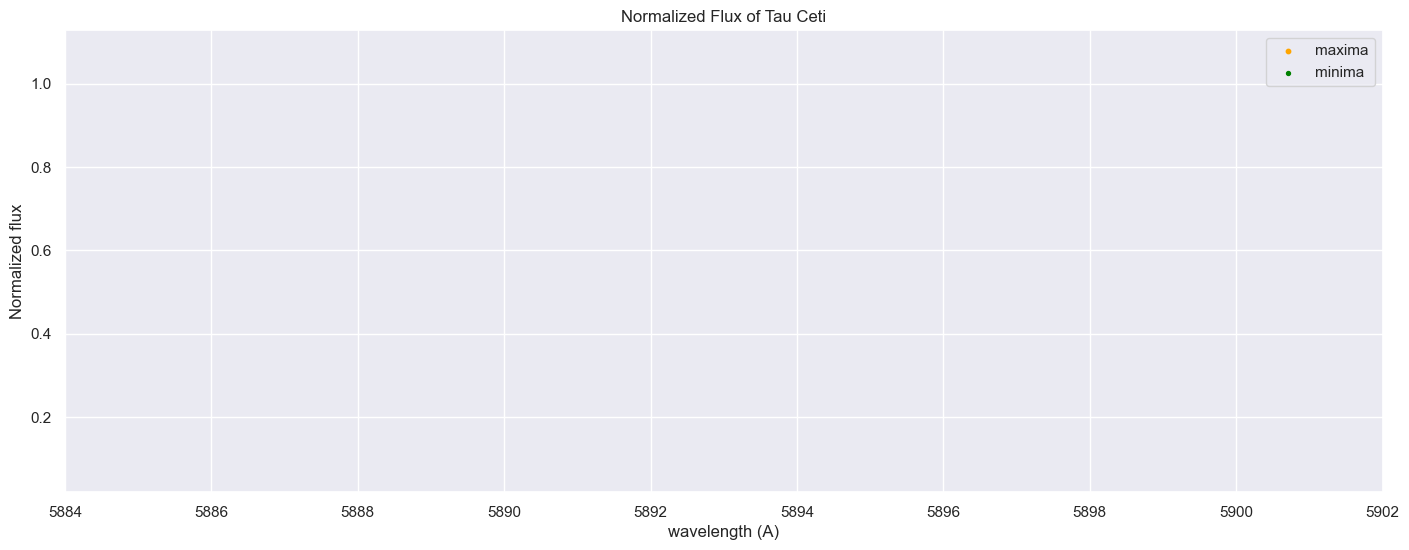

In [458]:
#visualization:
plt.figure(figsize = (17,6))
plt.plot(wl,fl)
plt.scatter(maxx, maxy,s = 10, c = 'orange', label = 'maxima')
plt.scatter(minx,miny,s = 8, c = 'green', label = 'minima')
plt.xlabel('wavelength (A)')
plt.ylabel('Normalized flux')
plt.title('Normalized Flux of Tau Ceti')
plt.legend()
plt.xlim(5884,5902)
plt.show()

In [459]:
def find_range(x,y, intial_guess = False):
    ''' Given the parameters of a spectra, it will find the ranges of possible gaussian candidates. 
    the aim is for it to also give inital parameters estimations for curve fitting'''
    ranges = []
    outs = []
    minx, miny = minima_scanner_with_thresholds(wl,fl, [0.4,0.8])
    maxx, maxy = simple_maxima(x, y, 0.9)
    insertions = np.searchsorted(maxx, minx) #gives at which indeces to put the mininima in the maxima array to be sorted still. 
    
    tempxr = []
    tempyr = []
    tempxl = []
    tempyl = []
    
    
    for i in insertions: 
        tempxr.append(maxx[i])
        tempyr.append(maxy[i])
        tempxl.append(maxx[i-1])
        tempyl.append(maxy[i-1])

    for j in np.arange(len(tempxl)): 
        temprange = []
        tempout = []
        for i in np.arange(len(x)):
            if x[i] > tempxl[j] and x[i] < tempxr[j]:
                temprange.append(x[i])
                tempout.append(y[i])
        ranges.append(temprange)
        outs.append(tempout)
        
    #finds inital guesses:
    if intial_guess: 
        
        amps = []
        means = []
        stds = []
        for i in np.arange(len(ranges)):
            amps.append(min(outs[i]))
            means.append(ranges[i][np.argmin(outs[i])])
            stds.append(np.std(outs[i]))
        
        
        return ranges, outs, amps, means, stds
                
   #just returns ranges for graphing purposes 
    else:
        return ranges, outs

In [460]:
test_range = [0,1,2,5,6,7,10]

test_input = [3,8]

np.searchsorted(test_range, test_input)

# this gives the right indices, so take the left as i-1 

array([3, 6], dtype=int64)

In [461]:
testmaxx, testouts = find_range(wl,fl) #this gives right directional values 

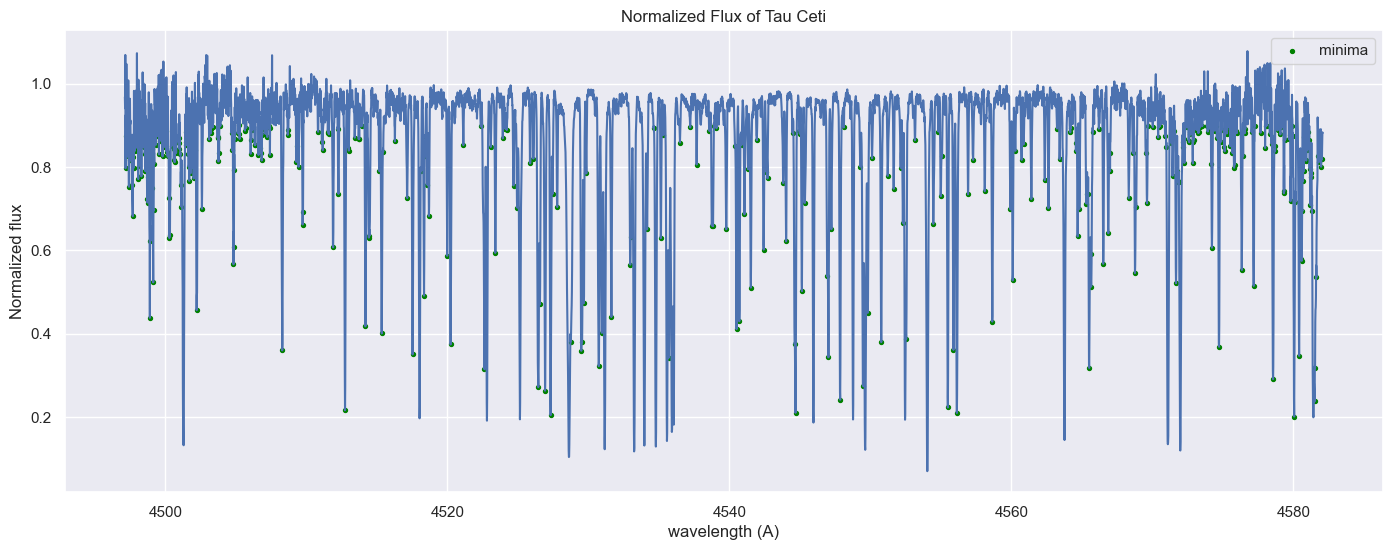

In [464]:
plt.figure(figsize = (17,6))
plt.plot(wl,fl)
# plt.scatter(testmaxx, testmaxy,s = 10, c = 'orange', label = 'maxima')
plt.scatter(minx,miny,s = 8, c = 'green', label = 'minima')
plt.xlabel('wavelength (A)')
plt.ylabel('Normalized flux')
plt.title('Normalized Flux of Tau Ceti')
plt.legend()
#plt.xlim(5884,5902)
plt.show()

In [465]:
# testmaxx[1:4]

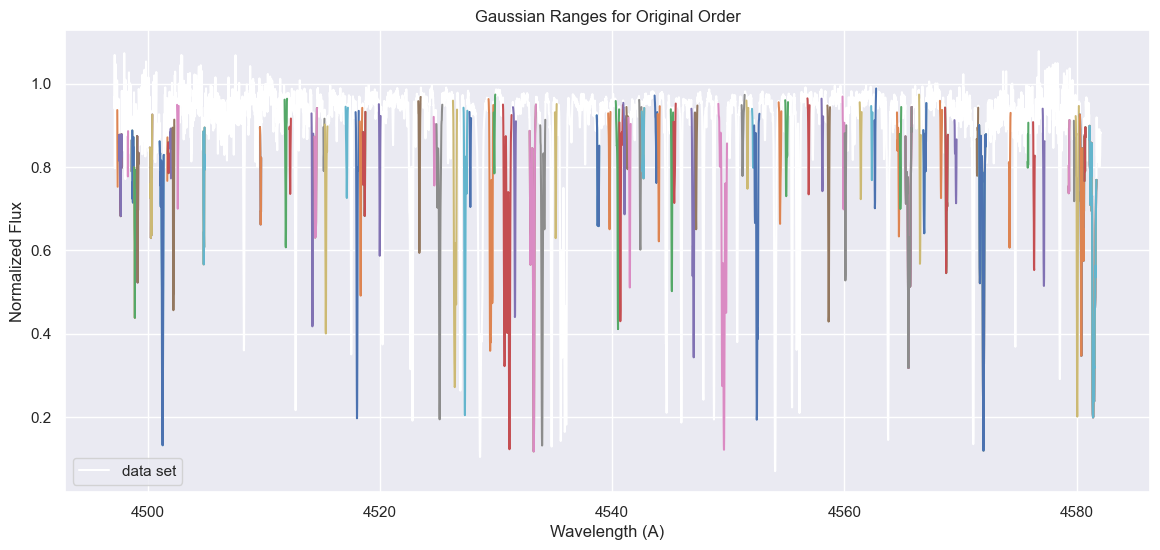

In [466]:
plt.figure(figsize = (14,6))
plt.plot(wl, fl, c = 'white', label = 'data set')
plt.title('Gaussian Ranges for Original Order')
plt.xlabel('Wavelength (A)')
plt.ylabel('Normalized Flux')
for i in np.arange(len(testmaxx)):
    plt.plot(testmaxx[i], testouts[i])
plt.legend()

In [467]:
#testmaxx[0], testouts[0]

In [468]:
#plt.plot(testmaxx[0], testouts[0])

In [469]:
def plot_gaussian_tests(index):
    plt.figure(figsize = (1,6))
    plt.plot(testmaxx[index],testouts[index], label = 'plotted values', c = 'grey')
    plt.scatter(testmaxx[index],testouts[index], label = 'Pixels', c = 'orange')
    plt.title('test gaussian ranges; '+ str(index) + ' of ' + str(len(testmaxx)))
    plt.xlabel('Wavelength (A)')
    plt.ylabel('Normalized Flux') 
    plt.ylim(0.2,1.1)
    plt.legend()
    plt.show()

In [470]:
# widgets.interact(plot_gaussian_tests, index = widgets.Play(interval = 500,min = 0, max = len(testmaxx)-1))

Notes:
1. ranges 8 and 9 are identical -- probably due to the max being v close to the threshold that they jointly skip the max that separates them, causing identical ranges 
>is it better to extend the limits? 

## Gaussian Curve Fitting

In [471]:
def gaussian(x,a, b, c):
    '''a is amplitude, b is  the mean (where i think it is), c is standard deviation (sqrt(variance))''' 
    #offset = x[0] #good estimate
    return -a*np.e**(-(x-b)**2/(2*c**2)) + 1 # + offset 

In [472]:
def general_gaussian(x,y, index = 0):
    ''' Curve fits gaussians to the ranges we find in the find_range function
    requires intial_guess = True for find_ranges()'''
    domains, ranges, amps, means, stds = find_range(x,y, intial_guess = True)
    b_fit, cov = curve_fit(gaussian, domains[index], ranges[index], p0 = [amps[index],means[index],stds[index]], absolute_sigma=True)
    return b_fit

In [473]:
# test = general_gaussian(wl,fl, 0)
# index = 1
# b_fit, cov = curve_fit(gaussian,domains[index], ranges[index], p0 = [amps[index],means[index],stds[index]], absolute_sigma=True)

In [474]:
#finding intital parameters:
#let it be found in the find_ranges?
domains, ranges, amps, means, stds = find_range(wl,fl, intial_guess = True)

In [475]:
domains, ranges, amps, means, stds = find_range(wl,fl, intial_guess = True)

In [476]:
# for i in np.arange(len(domains)):
#     print(len(domains[i]) == len(ranges[i]))

In [477]:
ps = {'Amplitude': amps, 'Means': means, 'Standard Deviations': stds}
inital_parameters = pd.DataFrame(ps)

In [478]:
inital_parameters

,Amplitude,Means,Standard Deviations
0,0.796932,4497.164784,0.000000
1,0.752720,4497.404805,0.075374
2,0.682275,4497.674843,0.059908
3,0.682275,4497.674843,0.059908
4,0.682275,4497.674843,0.059908
...,...,...,...
125,0.199681,4581.409150,0.235099
126,0.199681,4581.409150,0.235099
127,0.199681,4581.409150,0.235099
128,0.199681,4581.409150,0.235099


In [479]:
#index = 9
# bfit, cov = curve_fit(gaussian,domains[index], ranges[index], p0 = [amps[index],means[index],stds[index]], absolute_sigma=True)

In [480]:
# test_gaussian = gaussian(domains[index], bfit[0],bfit[1],bfit[2])

In [481]:
def plot_tests(index = 0):
    bfit, cov = curve_fit(gaussian,domains[index], ranges[index], p0 = [amps[index],means[index],stds[index]], absolute_sigma=True)
    test_gaussian = gaussian(domains[index], bfit[0],bfit[1],bfit[2])
    
    plt.plot(domains[index], ranges[index], label = 'Data')
    plt.plot(domains[index], test_gaussian, label = 'Fit')
    plt.title('Plotting Gaussian Fit to Data')
    plt.ylabel('Normalized Flux')
    plt.xlabel('Wavelength')
    plt.legend()
    #print('the guestimated PSF value is: ', np.round(bfit[0],3))
    return bfit[2]

In [483]:
widgets.interact(plot_tests, index = (0,100,1))

interactive(children=(IntSlider(value=0, description='index'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_tests(index=0)>

In [484]:
def return_psf(index = 0):
    bfit, cov = curve_fit(gaussian,domains[index], ranges[index], p0 = [amps[index],means[index],stds[index]], absolute_sigma=True)
    test_gaussian = gaussian(domains[index], bfit[0],bfit[1],bfit[2])
    return bfit[2] #this is the spread 

In [486]:
widgets.interact(return_psf, index = (0,92,1))



interactive(children=(IntSlider(value=0, description='index', max=92), Output()), _dom_classes=('widget-intera…

<function __main__.return_psf(index=0)>

## Making a histogram of one order

In [487]:
#this works for the most part 

In [488]:
psfs = []

for i in np.arange(0,93):
    #this skips the bad fits#
    try:
        psf = return_psf(i)
        if psf >0:
            psfs.append(psf)
    except:
        pass
    

C:\Users\alica\AppData\Local\Temp\ipykernel_36060\386542903.py:4: RuntimeWarning: invalid value encountered in true_divide
  return -a*np.e**(-(x-b)**2/(2*c**2)) + 1 # + offset


In [489]:
# psfs

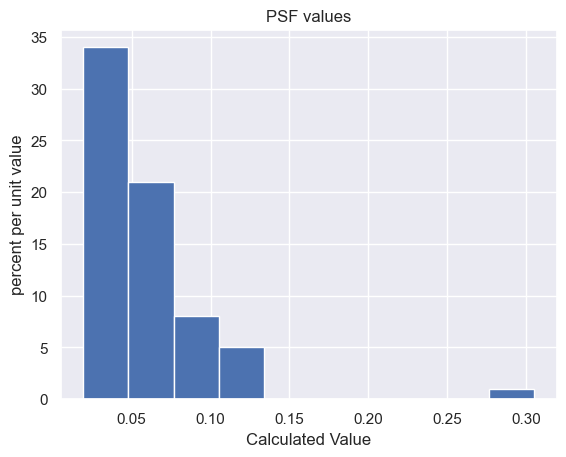

In [490]:
plt.hist(np.abs(psfs))
plt.title('PSF values')
plt.xlabel('Calculated Value')
plt.ylabel('percent per unit value')
plt.show()

In [491]:
np.median(psfs)

0.048713447606160434

## Using Chi Squared to Determine a Goodness of Fit

In [492]:
def chi(model, data):
    '''given two arrays of the same length,
    calculate chi squared'''
    return np.sum((data - model) ** 2)

In [493]:
#get things injected and recovered and classify the things recovered 
#critical part of write up 

## Generalizing with all data:

### reading in pickle file

In [52]:
import pickle

In [60]:
with open('./shifted_values.pkl', 'rb') as f:
     loaded_data = pickle.load(f)


loaded_data

{'wavelength': 0     [4431.46137068054, 4431.476152444564, 4431.490...
 1     [4464.045010302595, 4464.059900753942, 4464.07...
 2     [4497.119781202617, 4497.134781979524, 4497.14...
 3     [4530.68121275581, 4530.696325481602, 4530.711...
 4     [4564.750958699148, 4564.76618506938, 4564.781...
                             ...                        
 66    [9061.78623925518, 9061.816466120454, 9061.846...
 67    [9486.57628353487, 9486.607927347213, 9486.639...
 68    [9637.169683115359, 9637.201829253212, 9637.23...
 69    [9792.632159733768, 9792.664824438625, 9792.69...
 70    [9953.17398115629, 9953.207181371019, 9953.240...
 Name: shifted wavelengths, Length: 71, dtype: object,
 'flux': 0     [0.8949158314042824, 0.7815706774264399, 0.828...
 1     [0.9304602218385664, 0.9055602214297426, 0.804...
 2     [0.9681062116715451, 0.9410797799020679, 1.068...
 3     [0.442616295897608, 0.43149351085405907, 0.322...
 4     [0.7329985280363767, 0.816532642581396, 0.6904...
           

## Time to find All the PSF values baby!

In [61]:
wls = loaded_data['wavelength']
fls = loaded_data['flux']
order = np.arange(len(wls))

In [425]:
order  

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70])

In [426]:
#there are 70 orders to work with: here are the ranges of values:

print(wls[0][0])
print(wls[-1:][len(wls[:-1])])

4431.46137068054
[ 9953.17398116  9953.20718137  9953.2403817  ... 10140.50394054
 10140.53776562 10140.57159082]


In [427]:
#okay well i tried to get that to work but thats besides the point

In [428]:
all_psfs = psfs

In [494]:
#first use find_ranges to get initial paramters:

def the_big_function(order = 0):
    psfs_test = []
    wl = wls[order]
    fl = fls[order]
    ming, mingy = minima_scanner_with_thresholds(wls[order], fls[order],[0.2,0.8])
    maxg, maxgy = simple_maxima(wls[g], fls[g], np.percentile(fls[order],90))
    
    domains, ranges, amps, means, stds = find_range(wl, fl, True)
    
    for d in np.arange(len(domains)):
        try:
            psf = return_psf(d)
            psfs_test.append(psf)
        except:
            pass
    return psfs_test

In [496]:
# the_big_function(1)

In [ ]:

for wls in np.arange(len(wls):
    for i in np.arange(0,93):
        #this skips the bad fits#
        try:
            psf = return_psf(i)
            psfs.append(psf)
        except:
            pass
    

In [431]:
g = 60
# find_range(wls[g],fls[g], True)

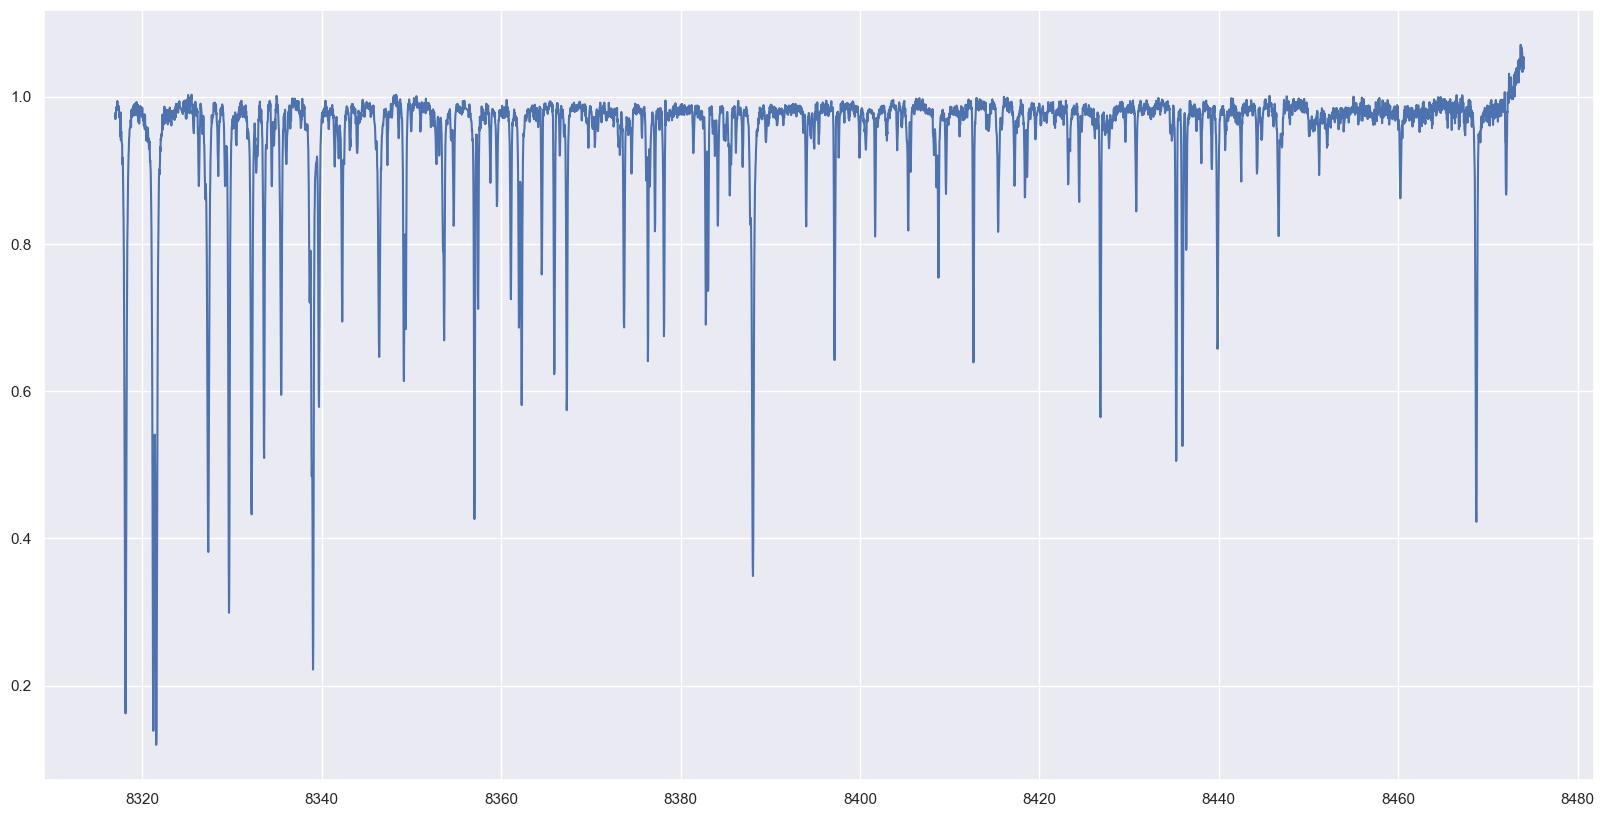

In [432]:
plt.figure(figsize = (20,10))
plt.plot(wls[g],fls[g])

In [440]:
ming, mingy = minima_scanner_with_thresholds(wls[g], fls[g],[0.2,0.8])

maxg, maxgy = simple_maxima(wls[g], fls[g], np.percentile(fls[g],90))

In [500]:
# find_range(wls[g],fls[g], True)

In [499]:
 # insertiong = np.searchsorted(maxg, ming)

In [498]:
# print(insertiong)

In [497]:
# maxg

In [244]:
[np.percentile(fls[g],0.1),np.percentile(fls[g],8)]

[0.1644023343439366, 0.8831785166412662]